In [20]:
import pandas as pd
import numpy as np
import seaborn as sns

df_var = pd.read_csv('variabilidad.csv')
df_buf = pd.read_csv('buffers.csv')
df_ral = pd.read_csv('df_full.csv')

#df_var.head()
#df_buf.head()
df_ral.head()

,Fecha,ralenti_total_h,ralenti_h_sim,reduccion,viajes_dia,dist_total_dia,unidades_activas,weekday,month,pred
0,2025-01-01,76.000009,86.013001,-10.012992,58,58,33,2,1,114.621232
1,2025-01-02,580.304543,630.235891,-49.931348,249,249,86,3,1,573.526295
2,2025-01-03,907.386416,948.611065,-41.224649,415,415,114,4,1,958.579617
3,2025-01-04,447.028728,511.648628,-64.619900,289,289,94,5,1,608.581171
4,2025-01-05,1002.519534,1015.668552,-13.149018,355,355,99,6,1,924.690705



--- HOME ---

-  % Rutas Críticas:  15.1%  (Total: 68 rutas)
   *Criterio: Rutas con Coeficiente de Variación > 6.66*

-  Variabilidad Promedio:  3.79 (CV)
   *un valor cercano a 0.5 o más indica alta inestabilidad operativa*

-  Tiempo Buffer Promedio: 47712.6 minutos
   *es el 'colchón' de seguridad promedio se le agrega*

----------------------------------------



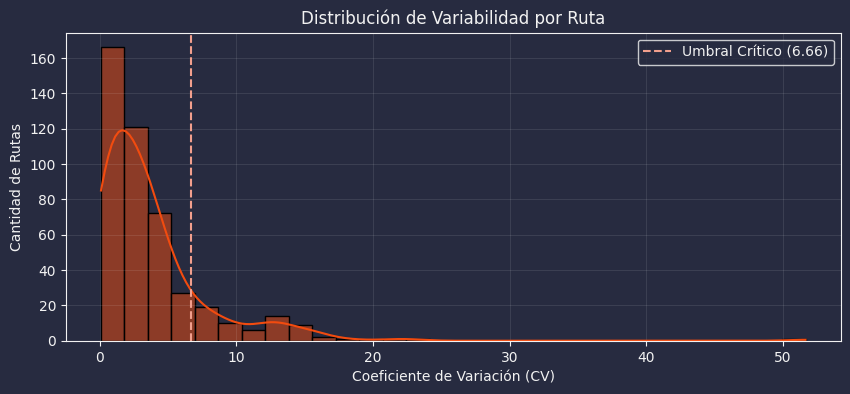

In [27]:
# métricas clave

# Variabilidad (Coeficiente de Variación - CV), CV nos dice qué tan "caótica" es una ruta comparada con su duración
# Fórmula: Desviación Estándar / Media
df_var['mean_time_safe'] = df_var['mean_time'].replace(0, np.nan) # Evitamos división por cero reemplazando ceros con NaN temporalmente
df_var['CV'] = df_var['std_time'] / df_var['mean_time_safe']

# Cuáles son las "Rutas Críticas"
# Crítica: con muy alta variabilidad.
umbral_critico = df_var['CV'].quantile(0.85) # percentil 85 (top 15% más inestable) como corte
df_var['Es_Critica'] = df_var['CV'] > umbral_critico

# KPIs

# KPI 1: Porcentaje de Rutas Críticas
total_rutas = len(df_var)
rutas_criticas = df_var['Es_Critica'].sum()
kpi_pct_criticas = (rutas_criticas / total_rutas) * 100

# KPI 2: Variabilidad Promedio (de toda la operación)
kpi_variabilidad_promedio = df_var['CV'].mean()

# KPI 3: Tiempo de Buffer Promedio
# aquí es cuánto tiempo extra estamos recomendando agregar por viaje en promedio
kpi_buffer_promedio = df_var['buffer_recomendado'].mean()

# resultados para streamlit
print(f"""
--- HOME ---

-  % Rutas Críticas:  {kpi_pct_criticas:.1f}%  (Total: {rutas_criticas} rutas)
   *Criterio: Rutas con Coeficiente de Variación > {umbral_critico:.2f}*

-  Variabilidad Promedio:  {kpi_variabilidad_promedio:.2f} (CV)
   *un valor cercano a 0.5 o más indica alta inestabilidad operativa*

-  Tiempo Buffer Promedio: {kpi_buffer_promedio:.1f} minutos
   *es el 'colchón' de seguridad promedio se le agrega*

----------------------------------------
""")

# gráfico para ver la distribución
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURACIÓN DE COLORES ---
plt.rcParams['figure.facecolor'] = '#272B40'
plt.rcParams['axes.facecolor'] = '#272B40'
plt.rcParams['text.color'] = '#F2F2F2'
plt.rcParams['axes.labelcolor'] = '#F2F2F2'
plt.rcParams['xtick.color'] = '#F2F2F2'
plt.rcParams['ytick.color'] = '#F2F2F2'
plt.rcParams['axes.edgecolor'] = '#F2F2F2'

plt.figure(figsize=(10, 4))

# Histograma -> Color Naranja Intenso (#F24B0F)
sns.histplot(df_var['CV'], bins=30, color='#F24B0F', kde=True)

# Línea de Umbral -> Color Salmón Claro (#F29F8D) para contraste
plt.axvline(umbral_critico, color='#F29F8D', linestyle='--', label=f'Umbral Crítico ({umbral_critico:.2f})')

plt.title('Distribución de Variabilidad por Ruta', color='#F2F2F2')
plt.xlabel('Coeficiente de Variación (CV)', color='#F2F2F2')
plt.ylabel('Cantidad de Rutas', color='#F2F2F2')

# Leyenda con fondo oscuro
plt.legend(facecolor='#272B40', edgecolor='#F2F2F2', labelcolor='#F2F2F2')
plt.grid(True, color='#F2F2F2', alpha=0.1)

plt.show()

La gráfica muestra cómo la mayoría de las rutas son normales, pero hay una cola larga a la derecha que son las críticas, que rompen la operación.


--- KPIs DE RALENTÍ ---

- Ralentí Total Real:221,730 h
   (Dato Actual del periodo)

- Ralentí Proyectado: 226,308 h
   (Línea Base / Referencia)

- Horas Ahorradas: 4,578 h
   (Diferencia a favor)

-  % Reducción vs Proyección: 2.02%
impacto del modelo



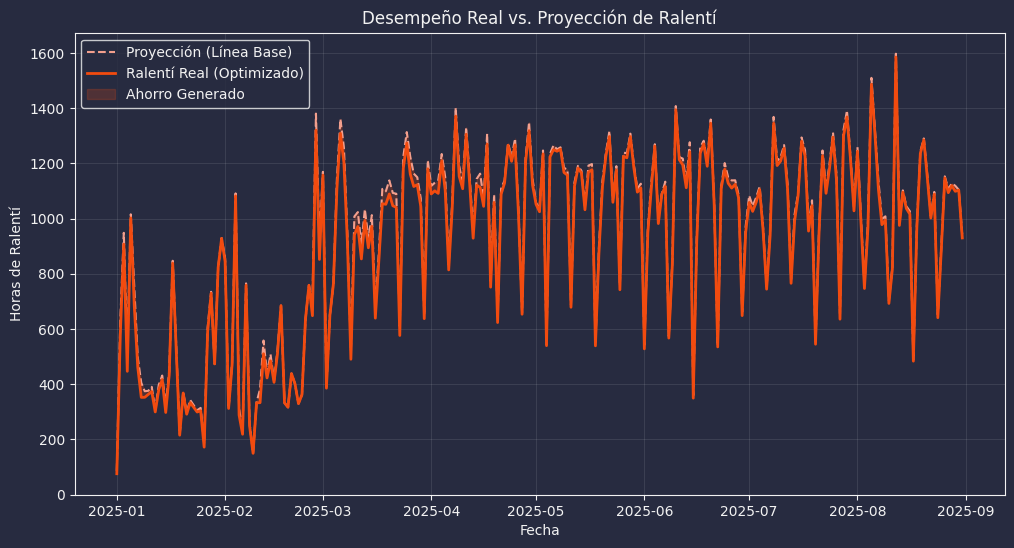

In [25]:
# cálculos de ralentí

df_full = pd.read_csv('df_full.csv')
df_full['Fecha'] = pd.to_datetime(df_full['Fecha'])

# métricas
# Proyección: 'ralenti_h_sim' (lo que se esperaba)
# Realidad: 'ralenti_total_h' (lo que se pasó)

proyeccion_total = df_full['ralenti_h_sim'].sum()
realidad_total = df_full['ralenti_total_h'].sum()

# Ahorro = Lo que proyectamos perder de tiempo MENOS lo que realmente se perdió
ahorro_horas = proyeccion_total - realidad_total
pct_reduccion = (ahorro_horas / proyeccion_total) * 100

# resultados
print(f"""
--- KPIs DE RALENTÍ ---

- Ralentí Total Real:{realidad_total:,.0f} h
   (Dato Actual del periodo)

- Ralentí Proyectado: {proyeccion_total:,.0f} h
   (Línea Base / Referencia)

- Horas Ahorradas: {ahorro_horas:,.0f} h
   (Diferencia a favor)

-  % Reducción vs Proyección: {pct_reduccion:.2f}%
impacto del modelo
""")

# --- APLICACIÓN DE LA PALETA COMPLETA ---
# Fondo: #272B40
# Texto: #F2F2F2
# Línea Real: #F24B0F (Naranja Intenso)
# Línea Proy: #F29F8D (Salmón/Naranja Claro)

# Configurar el estilo global para que coincida con el fondo oscuro
plt.rcParams['figure.facecolor'] = '#272B40'
plt.rcParams['axes.facecolor'] = '#272B40'
plt.rcParams['text.color'] = '#F2F2F2'
plt.rcParams['axes.labelcolor'] = '#F2F2F2'
plt.rcParams['xtick.color'] = '#F2F2F2'
plt.rcParams['ytick.color'] = '#F2F2F2'
plt.rcParams['axes.edgecolor'] = '#F2F2F2'

# GRÁFICA REAL VS PROYECCIÓN
plt.figure(figsize=(12, 6))

# línea de proyección (lo que se esperaba) -> COLOR SALMÓN CLARO #F29F8D
sns.lineplot(data=df_full, x='Fecha', y='ralenti_h_sim',
             label='Proyección (Línea Base)', color='#F29F8D', linestyle='--')

# línea real (lo que se pasó) -> COLOR NARANJA INTENSO #F24B0F
sns.lineplot(data=df_full, x='Fecha', y='ralenti_total_h',
             label='Ralentí Real (Optimizado)', color='#F24B0F', linewidth=2)

# la diferencia entre curvas es la parte coloreada -> COLOR NARANJA INTENSO CON TRANSPARENCIA
plt.fill_between(df_full['Fecha'], df_full['ralenti_total_h'], df_full['ralenti_h_sim'],
                 color='#F24B0F', alpha=0.2, label='Ahorro Generado')

plt.title('Desempeño Real vs. Proyección de Ralentí', color='#F2F2F2')
plt.ylabel('Horas de Ralentí', color='#F2F2F2')
plt.xlabel('Fecha', color='#F2F2F2')

# Ajustar leyenda para que sea legible sobre fondo oscuro
plt.legend(facecolor='#272B40', edgecolor='#F2F2F2', labelcolor='#F2F2F2')

# Rejilla sutil en blanco/gris claro
plt.grid(True, color='#F2F2F2', alpha=0.1)

plt.show()

In [28]:
# Guardar los datos calculados para usarlos en VS Code
df_var.to_csv('datos_variabilidad_final.csv', index=False)
df_full.to_csv('datos_ralenti_diario.csv', index=False)